Author: **Stefano Petrocchi**


## Dependencies and Variables:

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import datetime
import os
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow.python.util import deprecation
import pickle


deprecation._PRINT_DEPRECATION_WARNINGS = False

disable_eager_execution() #To execute the gradient

BASE_PATH = "drive/MyDrive/Petrocchi"
MODELS_PATH = BASE_PATH + "/models"
DATA_PATH = BASE_PATH + "/data/"
CHECKPOINT_PATH = BASE_PATH + "/checkpoints"
HISTORY_PATH = BASE_PATH + "/history"

labels_dict = {
  "0": "BASELINE",
  "1": "MASS BENIGN",
  "2": "MASS MALIGNANT",
  "3": "CALCIFICATION BENIGN",
  "4": "CALCIFICATION MALIGNANT"
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -q pyyaml h5py

In [4]:
!pip install import_ipynb

In [5]:
# Get util functions
import import_ipynb
import drive.MyDrive.Petrocchi.util.preprocessing as preprocessing
import drive.MyDrive.Petrocchi.util.models as my_models
import drive.MyDrive.Petrocchi.util.visualization as visual
import drive.MyDrive.Petrocchi.util.SVM as svm

importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/preprocessing.ipynb
"load_images_and_lables" function loaded
"preprocess_normalize_images" function loaded
"deprocess_image_to_RGB" function loaded
"deprocess_image" function loaded
"datagen" class loaded
"binary_subdivision" function loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/models.ipynb
"tiny_net" CNN loaded
"mammo_net" CNN loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/visualization.ipynb
"plot_history" function loaded
"plot_roc_curve" function loaded
"plot_confusion_matrix" function loaded
"generate_pattern" function loaded
"display_filters_patterns" function loaded
"display_features_maps" function loaded
"generate_pattern_RGB" function loaded
"display_filters_patterns" function loaded
importing Jupyter notebook from /content/drive/MyDrive/Petrocchi/util/SVM.ipynb
"create_feature_extractor" function loaded
"extract_features" function loaded
"train_s

## Data Loading:

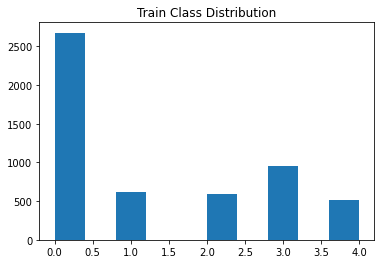

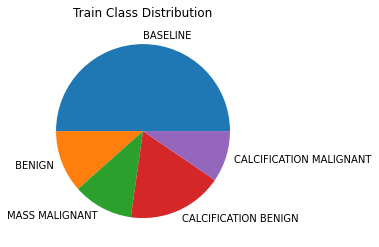

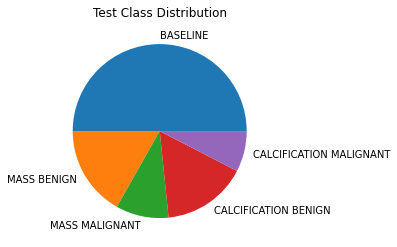

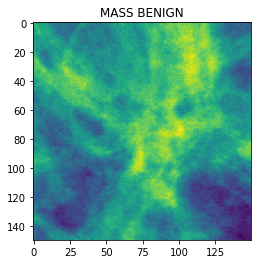

In [6]:
train_images, train_labels= preprocessing.load_images_and_lables(DATA_PATH + 'train_tensor.npy', DATA_PATH + 'train_labels.npy')
test_images, test_labels= preprocessing.load_images_and_lables(DATA_PATH + 'public_test_tensor.npy', DATA_PATH + 'public_test_labels.npy')

# Class Distribution
plt.hist(train_labels)
plt.title("Train Class Distribution")
plt.show()

unique, counts = np.unique(train_labels, return_counts=True)
plt.pie(counts, labels = ["BASELINE"," BENIGN","MASS MALIGNANT","CALCIFICATION BENIGN","CALCIFICATION MALIGNANT"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(test_labels, return_counts=True)
plt.pie(counts, labels = ["BASELINE","MASS BENIGN","MASS MALIGNANT","CALCIFICATION BENIGN","CALCIFICATION MALIGNANT"])
plt.title('Test Class Distribution')
plt.show()

# Plot an example
img_index = 5
plt.imshow(train_images[img_index,:,:])
plt.title(labels_dict[str(train_labels[img_index])])
plt.show()

## General Data Preprocessing:

Normalize and convert to RGB:

In [7]:
# I also need to convert back to numpy array using eval()
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session()
with sess.as_default():
  print(train_images.shape)
  pp_train_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(preprocessing.preprocess_normalize_images(train_images, train_images.mean(), train_images.std()))).eval()
  print(pp_train_images.shape)

  print(test_images.shape)
  pp_test_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(preprocessing.preprocess_normalize_images(test_images, train_images.mean(), train_images.std()))).eval()
  print(pp_test_images.shape)

(5352, 150, 150)
(5352, 150, 150, 3)
(672, 150, 150)
(672, 150, 150, 3)


Test Augmentation:

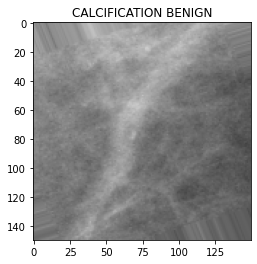

In [8]:
# Test: show random augmented image
for batch in preprocessing.datagen.flow(pp_train_images, train_labels, batch_size=1):
    plt.title(labels_dict[str(batch[1][0])])
    imgplot = plt.imshow(preprocessing.deprocess_image_to_RGB(batch[0][0][:,:,:]))
    break

plt.show()

Binary subdivision:

Benagn and Malignant
(2676, 150, 150, 3)
(2676,)
(336, 150, 150, 3)
(336,)


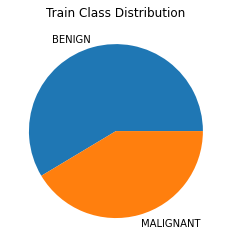

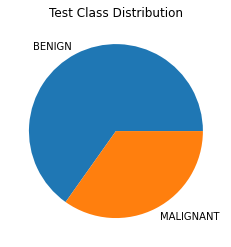

In [9]:
# 0: BENIGN, 1: MALIGNANT
bm_train_images, bm_train_labels, bm_test_images, bm_test_labels = preprocessing.binary_subdivision( 
    [1,3], [2,4], pp_train_images, train_labels, pp_test_images, test_labels)  

print("Benagn and Malignant")
print(bm_train_images.shape)
print(bm_train_labels.shape)
print(bm_test_images.shape)
print(bm_test_labels.shape)

# Class Distribution
unique, counts = np.unique(bm_train_labels, return_counts=True)
plt.pie(counts, labels = ["BENIGN","MALIGNANT"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(bm_test_labels, return_counts=True)
plt.pie(counts, labels = ["BENIGN","MALIGNANT"])
plt.title('Test Class Distribution')
plt.show()

# PreTrained Benign VS Malignant Classifiers

### Split:

(2140, 150, 150, 3)
(2140,)
(536, 150, 150, 3)
(536,)


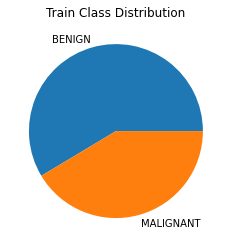

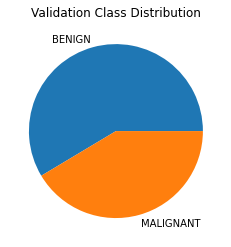

In [10]:
bm_train_images, bm_val_images, bm_train_labels, bm_val_labels = train_test_split(bm_train_images, bm_train_labels, test_size=0.2, random_state=171997, stratify=bm_train_labels)

print(bm_train_images.shape)
print(bm_train_labels.shape)
print(bm_val_images.shape)
print(bm_val_labels.shape)

# Class Distribution
unique, counts = np.unique(bm_train_labels, return_counts=True)
plt.pie(counts, labels = ["BENIGN","MALIGNANT"])
plt.title('Train Class Distribution')
plt.show()

unique, counts = np.unique(bm_val_labels, return_counts=True)
plt.pie(counts, labels = ["BENIGN","MALIGNANT"])
plt.title('Validation Class Distribution')
plt.show()

###General Parameters for training:

In [11]:
K.clear_session()

In [12]:
# Training parameters that are good for all models

# From ISMMS paper 32
# From Girona & Manchester paper 128
BATCH_SIZE = 107 # to have even batches 
STEPS_PER_EPOCH = len(bm_train_images) // BATCH_SIZE # 20
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.00001) # From Ecuador/Brazil paper
LOSS = 'binary_crossentropy'

# Large values ensures to not lose better weights 
MAX_EPOCHS = 1000 
PATIENCE = 50 

# Automatically restore best weights after early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)

##Transfer Learning

### VGG16 Transfer Learning:

In [ ]:
from tensorflow.keras.applications import VGG16

VGG16_TL_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
VGG16_TL_base.trainable = False

VGG16_TL_bm = models.Sequential(name = "VGG16_TL_benign_malignant")
VGG16_TL_bm.add(VGG16_TL_base)

VGG16_TL_bm.add(layers.Flatten(name = "flatten"))
VGG16_TL_bm.add(layers.Dropout(0.2))
VGG16_TL_bm.add(layers.Dense(4096, activation='relu', name = "fully_connected_0"))
VGG16_TL_bm.add(layers.Dropout(0.2))
VGG16_TL_bm.add(layers.Dense(4096, activation='relu', name = "fully_connected_1"))
VGG16_TL_bm.add(layers.Dropout(0.1))
VGG16_TL_bm.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

VGG16_TL_bm.summary()

VGG16_TL_bm.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/VGG16_TL_bm/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

58892288/58889256 [==============================] - 1s 0us/step
Model: "VGG16_TL_benign_malignant"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
fully_connected_0 (Dense)    (None, 4096)              33558528  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 4096)              16781312  
__________________________________________

Training:

In [ ]:
VGG16_TL_bm_history = VGG16_TL_bm.fit(preprocessing.datagen.flow(bm_train_images, bm_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (bm_val_images, bm_val_labels),
                       callbacks=[es_callback, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6709 - accuracy: 0.5846

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.60692, saving model to drive/MyDrive/Petrocchi/checkpoints/VGG16_TL_bm/checkpoint.ckpt
20/20 [==============================] - 23s 611ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6709 - accuracy: 0.5846 - val_loss: 0.6069 - val_accuracy: 0.6455
Epoch 2/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6256 - accuracy: 0.6336
Epoch 00002: val_loss improved from 0.60692 to 0.59461, saving model to drive/MyDrive/Petrocchi/checkpoints/VGG16_TL_bm/checkpoint.ckpt
20/20 [==============================] - 18s 910ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6256 - accuracy: 0.6336 - val_loss: 0.5946 - val_accuracy: 0.6810
Epoch 3/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6054 - accuracy: 0.6505
Epoch 00003: val_loss improved from 0.59461 to 0.57876, saving model to drive/MyDrive/Petrocchi/checkpoints/VGG16_TL_bm/checkpoint.ckpt
20/20 [

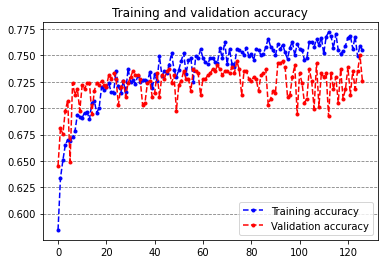

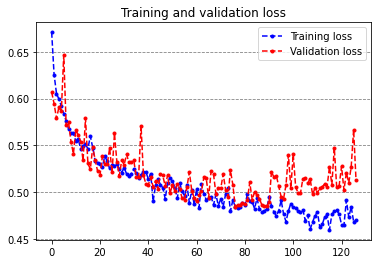

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/VGG16_TL_bm_history', 'wb') as file_pi:
        pickle.dump(VGG16_TL_bm_history.history, file_pi)

VGG16_TL_bm_history = pickle.load(open(HISTORY_PATH + '/VGG16_TL_bm_history', "rb"))

visual.plot_history(VGG16_TL_bm_history)

In [ ]:
train_loss, train_acc = VGG16_TL_bm.evaluate(bm_train_images, bm_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = VGG16_TL_bm.evaluate(bm_val_images, bm_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = VGG16_TL_bm.evaluate(bm_test_images, bm_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 77.99% 
Loss on train set: 0.4412
Accuracy on validation set: 71.27% 
Loss on validation set: 0.5225
Accuracy on test set: 69.64% 
Loss on test set: 0.5891


Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/VGG16_TL_bm/")
#VGG16_TL_bm.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
VGG16_TL_bm.save(os.path.join(MODELS_PATH,'VGG16_TL_bm.h5'))

### InceptionV3 Transfer Learning:

In [ ]:
from tensorflow.keras.applications import InceptionV3

InceptionV3_TL_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
InceptionV3_TL_base.trainable = False

InceptionV3_TL_bm = models.Sequential(name = "InceptionV3_TL_benign_malignant")
InceptionV3_TL_bm.add(InceptionV3_TL_base)

InceptionV3_TL_bm.add(layers.Flatten(name = "flatten"))
InceptionV3_TL_bm.add(layers.Dropout(0.2))
InceptionV3_TL_bm.add(layers.Dense(2048, activation='relu', name = "fully_connected_0"))
InceptionV3_TL_bm.add(layers.Dropout(0.2))
InceptionV3_TL_bm.add(layers.Dense(2048, activation='relu', name = "fully_connected_1"))
InceptionV3_TL_bm.add(layers.Dropout(0.1))
InceptionV3_TL_bm.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

InceptionV3_TL_bm.summary()

InceptionV3_TL_bm.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/InceptionV3_TL_bm/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

Model: "InceptionV3_TL_benign_malignant"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 18432)             0         
_________________________________________________________________
fully_connected_0 (Dense)    (None, 2048)              37750784  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 2048)              4196352   
_________________________________________________________________
dropout_5 (Dropout)          (None,

Training:

In [ ]:
InceptionV3_TL_bm_history = InceptionV3_TL_bm.fit(preprocessing.datagen.flow(bm_train_images, bm_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (bm_val_images, bm_val_labels),
                       callbacks=[es_callback, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.9034 - accuracy: 0.5785

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.61519, saving model to drive/MyDrive/Petrocchi/checkpoints/InceptionV3_TL_bm/checkpoint.ckpt
20/20 [==============================] - 18s 625ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.9034 - accuracy: 0.5785 - val_loss: 0.6152 - val_accuracy: 0.6959
Epoch 2/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6254 - accuracy: 0.6579
Epoch 00002: val_loss improved from 0.61519 to 0.59669, saving model to drive/MyDrive/Petrocchi/checkpoints/InceptionV3_TL_bm/checkpoint.ckpt
20/20 [==============================] - 9s 476ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6254 - accuracy: 0.6579 - val_loss: 0.5967 - val_accuracy: 0.6754
Epoch 3/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6136 - accuracy: 0.6528
Epoch 00003: val_loss improved from 0.59669 to 0.59441, saving model to drive/MyDrive/Petrocchi/checkpoints/InceptionV3_TL_bm/checkp

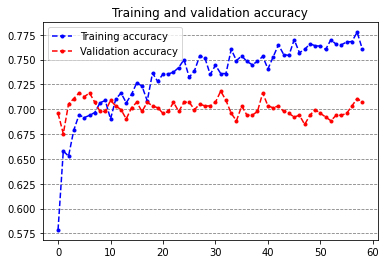

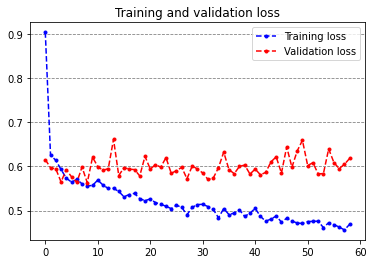

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/InceptionV3_TL_bm_history', 'wb') as file_pi:
        pickle.dump(InceptionV3_TL_bm_history.history, file_pi)

InceptionV3_TL_bm_history = pickle.load(open(HISTORY_PATH + '/InceptionV3_TL_bm_history', "rb"))

visual.plot_history(InceptionV3_TL_bm_history)

In [ ]:
train_loss, train_acc = InceptionV3_TL_bm.evaluate(bm_train_images, bm_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = InceptionV3_TL_bm.evaluate(bm_val_images, bm_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = InceptionV3_TL_bm.evaluate(bm_test_images, bm_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 71.96% 
Loss on train set: 0.5279
Accuracy on validation set: 69.78% 
Loss on validation set: 0.5675
Accuracy on test set: 72.32% 
Loss on test set: 0.5921


Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/InceptionV3_TL_bm/")
#InceptionV3_TL_bm.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
InceptionV3_TL_bm.save(os.path.join(MODELS_PATH,'InceptionV3_TL_bm.h5'))

### ResNet50 Transfer Learning:

In [ ]:
from tensorflow.keras.applications import ResNet50

ResNet50_TL_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
ResNet50_TL_base.trainable = False

ResNet50_TL_bm = models.Sequential(name = "ResNet50_TL_benign_malignant")
ResNet50_TL_bm.add(ResNet50_TL_base)

ResNet50_TL_bm.add(layers.Flatten(name = "flatten"))
ResNet50_TL_bm.add(layers.Dropout(0.2))
ResNet50_TL_bm.add(layers.Dense(512, activation='relu', name = "fully_connected_0"))
ResNet50_TL_bm.add(layers.Dropout(0.2))
ResNet50_TL_bm.add(layers.Dense(512, activation='relu', name = "fully_connected_1"))
ResNet50_TL_bm.add(layers.Dropout(0.1))
ResNet50_TL_bm.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

ResNet50_TL_bm.summary()

ResNet50_TL_bm.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/ResNet50_TL_bm/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

94773248/94765736 [==============================] - 1s 0us/step
Model: "ResNet50_TL_benign_malignant"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 51200)             0         
_________________________________________________________________
fully_connected_0 (Dense)    (None, 512)               26214912  
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 512)               262656    
_______________________________________

Training:

In [ ]:
ResNet50_TL_bm_history = ResNet50_TL_bm.fit(preprocessing.datagen.flow(bm_train_images, bm_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (bm_val_images, bm_val_labels),
                       callbacks=[es_callback, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.7080 - accuracy: 0.5579

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.61729, saving model to drive/MyDrive/Petrocchi/checkpoints/ResNet50_TL_bm/checkpoint.ckpt
20/20 [==============================] - 19s 698ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.7080 - accuracy: 0.5579 - val_loss: 0.6173 - val_accuracy: 0.6045
Epoch 2/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6669 - accuracy: 0.6042
Epoch 00002: val_loss improved from 0.61729 to 0.60617, saving model to drive/MyDrive/Petrocchi/checkpoints/ResNet50_TL_bm/checkpoint.ckpt
20/20 [==============================] - 9s 436ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6669 - accuracy: 0.6042 - val_loss: 0.6062 - val_accuracy: 0.6101
Epoch 3/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6574 - accuracy: 0.6005
Epoch 00003: val_loss did not improve from 0.60617
20/20 [==============================] - 10s 514ms/step - batch: 9.5000 - size: 107.000

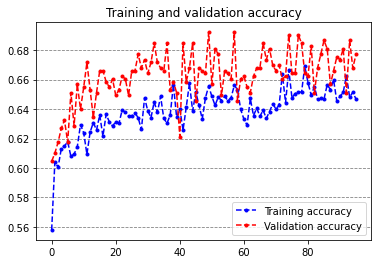

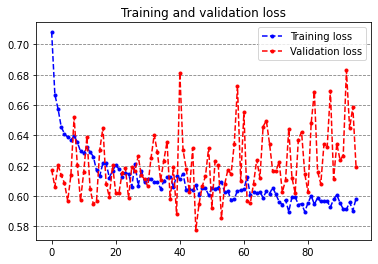

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/ResNet50_TL_bm_history', 'wb') as file_pi:
        pickle.dump(ResNet50_TL_bm_history.history, file_pi)

ResNet50_TL_bm_history = pickle.load(open(HISTORY_PATH + '/ResNet50_TL_bm_history', "rb"))

visual.plot_history(ResNet50_TL_bm_history)

In [ ]:
train_loss, train_acc = InceptionV3_FT_bm.evaluate(bm_train_images, bm_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = InceptionV3_FT_bm.evaluate(bm_val_images, bm_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = InceptionV3_FT_bm.evaluate(bm_test_images, bm_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 75.33% 
Loss on train set: 0.4647
Accuracy on validation set: 70.9% 
Loss on validation set: 0.5567
Accuracy on test set: 72.32% 
Loss on test set: 0.5744


Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/ResNet50_TL_bm/")
#ResNet50_TL_bm.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
ResNet50_TL_bm.save(os.path.join(MODELS_PATH,'ResNet50_TL_bm.h5'))

##Fine Tuning

### VGG16 Fine-Tuning:

In [ ]:
from tensorflow.keras.applications import VGG16

TOP_K_FROZEN_LAYERS = 8

VGG16_FT_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

VGG16_FT_bm = models.Sequential(name = "VGG16_FT_benign_malignant")
VGG16_FT_bm.add(VGG16_FT_base)

print("Frozen layers:")
for idx in range(TOP_K_FROZEN_LAYERS):
  print(VGG16_FT_base.layers[idx].name)
  VGG16_FT_base.layers[idx].trainable = False

VGG16_FT_bm.add(layers.Flatten(name = "flatten"))
VGG16_FT_bm.add(layers.Dropout(0.2))
VGG16_FT_bm.add(layers.Dense(4096, activation='relu', name = "fully_connected_0"))
VGG16_FT_bm.add(layers.Dropout(0.2))
VGG16_FT_bm.add(layers.Dense(4096, activation='relu', name = "fully_connected_1"))
VGG16_FT_bm.add(layers.Dropout(0.1))
VGG16_FT_bm.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

VGG16_FT_bm.summary()

VGG16_FT_bm.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/VGG16_FT_bm/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

Frozen layers:
input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
Model: "VGG16_FT_benign_malignant"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8192)              0         
_________________________________________________________________
fully_connected_0 (Dense)    (None, 4096)              33558528  
_________________________________________________________________
dropout_10 (Dropout)         (None, 4096)              0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 4096)              167813

Training:

In [ ]:
VGG16_FT_bm_history = VGG16_FT_bm.fit(preprocessing.datagen.flow(bm_train_images, bm_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (bm_val_images, bm_val_labels),
                       callbacks=[es_callback, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6473 - accuracy: 0.6061

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.62159, saving model to drive/MyDrive/Petrocchi/checkpoints/VGG16_FT_bm/checkpoint.ckpt
20/20 [==============================] - 25s 903ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6473 - accuracy: 0.6061 - val_loss: 0.6216 - val_accuracy: 0.6604
Epoch 2/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.5961 - accuracy: 0.6463
Epoch 00002: val_loss improved from 0.62159 to 0.56447, saving model to drive/MyDrive/Petrocchi/checkpoints/VGG16_FT_bm/checkpoint.ckpt
20/20 [==============================] - 13s 663ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.5961 - accuracy: 0.6463 - val_loss: 0.5645 - val_accuracy: 0.6157
Epoch 3/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.5788 - accuracy: 0.6664
Epoch 00003: val_loss improved from 0.56447 to 0.52874, saving model to drive/MyDrive/Petrocchi/checkpoints/VGG16_FT_bm/checkpoint.ckpt
20/20 [

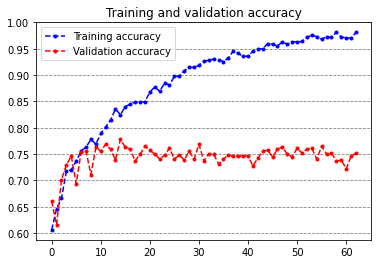

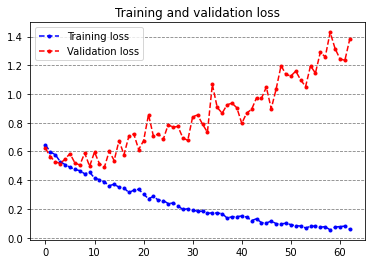

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/VGG16_FT_bm_history', 'wb') as file_pi:
        pickle.dump(VGG16_FT_bm_history.history, file_pi)

VGG16_FT_bm_history = pickle.load(open(HISTORY_PATH + '/VGG16_FT_bm_history', "rb"))

visual.plot_history(VGG16_FT_bm_history)

In [ ]:
train_loss, train_acc = VGG16_FT_bm.evaluate(bm_train_images, bm_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = VGG16_FT_bm.evaluate(bm_val_images, bm_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = VGG16_FT_bm.evaluate(bm_test_images, bm_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 85.28% 
Loss on train set: 0.3252
Accuracy on validation set: 75.93% 
Loss on validation set: 0.5381
Accuracy on test set: 70.83% 
Loss on test set: 0.6135


Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/VGG16_FT_bm/")
#VGG16_FT_bm.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
VGG16_FT_bm.save(os.path.join(MODELS_PATH,'VGG16_FT_bm.h5'))

### InceptionV3 Fine-Tuning:

In [13]:
from tensorflow.keras.applications import InceptionV3

InceptionV3_FT_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

InceptionV3_FT_bm = models.Sequential(name = "InceptionV3_FT_benign_malignant")
InceptionV3_FT_bm.add(InceptionV3_FT_base)

InceptionV3_FT_bm.add(layers.Flatten(name = "flatten"))
InceptionV3_FT_bm.add(layers.Dropout(0.2))
InceptionV3_FT_bm.add(layers.Dense(2048, activation='relu', name = "fully_connected_0"))
InceptionV3_FT_bm.add(layers.Dropout(0.2))
InceptionV3_FT_bm.add(layers.Dense(2048, activation='relu', name = "fully_connected_1"))
InceptionV3_FT_bm.add(layers.Dropout(0.1))
InceptionV3_FT_bm.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

InceptionV3_FT_bm.summary()

InceptionV3_FT_bm.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/InceptionV3_FT_bm/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

Model: "InceptionV3_FT_benign_malignant"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
fully_connected_0 (Dense)    (None, 2048)              37750784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
fully_connected_1 (Dense)    (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None,

Training:

In [14]:
InceptionV3_FT_bm_history = InceptionV3_FT_bm.fit(preprocessing.datagen.flow(bm_train_images, bm_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (bm_val_images, bm_val_labels),
                       callbacks=[es_callback])#, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.7059 - accuracy: 0.5636

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20/20 [==============================] - 49s 875ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.7059 - accuracy: 0.5636 - val_loss: 0.6361 - val_accuracy: 0.5765
Epoch 2/1000
20/20 [==============================] - 11s 539ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6382 - accuracy: 0.6266 - val_loss: 0.6390 - val_accuracy: 0.5914
Epoch 3/1000
20/20 [==============================] - 14s 730ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6181 - accuracy: 0.6500 - val_loss: 0.6351 - val_accuracy: 0.6007
Epoch 4/1000
20/20 [==============================] - 15s 748ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6153 - accuracy: 0.6570 - val_loss: 0.6296 - val_accuracy: 0.6250
Epoch 5/1000
20/20 [==============================] - 15s 757ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6028 - accuracy: 0.6664 - val_loss: 0.6319 - val_accuracy: 0.6306
Epoch 6/1000
20/20 [==============================] - 15s 770ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.5882 - accu

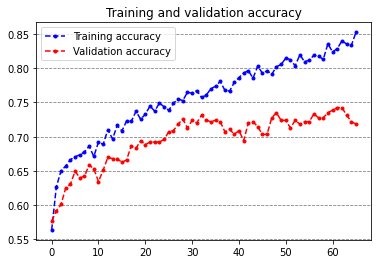

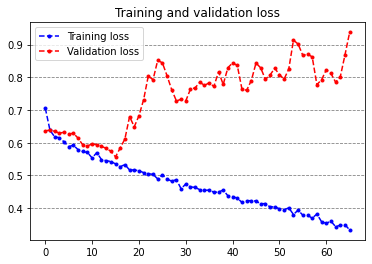

In [15]:
# Save and load history
with open(HISTORY_PATH + '/InceptionV3_FT_bm_history', 'wb') as file_pi:
        pickle.dump(InceptionV3_FT_bm_history.history, file_pi)

InceptionV3_FT_bm_history = pickle.load(open(HISTORY_PATH + '/InceptionV3_FT_bm_history', "rb"))

visual.plot_history(InceptionV3_FT_bm_history)

In [16]:
train_loss, train_acc = InceptionV3_FT_bm.evaluate(bm_train_images, bm_train_labels)
print(f"Accuracy on train set: {round(train_acc*100, 2)}% \nLoss on train set: {round(train_loss,4)}")
val_loss, val_acc = InceptionV3_FT_bm.evaluate(bm_val_images, bm_val_labels)
print(f"Accuracy on validation set: {round(val_acc*100, 2)}% \nLoss on validation set: {round(val_loss,4)}")
test_loss, test_acc = InceptionV3_FT_bm.evaluate(bm_test_images, bm_test_labels)
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

Accuracy on train set: 71.17% 
Loss on train set: 0.5368
Accuracy on validation set: 66.23% 
Loss on validation set: 0.6031
Accuracy on test set: 68.15% 
Loss on test set: 0.588


Load best weights and save:

In [17]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/InceptionV3_FT_bm/")
#InceptionV3_FT_bm.load_weights(best)

In [18]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
InceptionV3_FT_bm.save(os.path.join(MODELS_PATH,'InceptionV3_FT_bm.h5'))

### ResNet50 Fine-Tuning:

In [19]:
from tensorflow.keras.applications import ResNet50

TOP_K_FROZEN_LAYERS = 170

ResNet50_FT_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

ResNet50_FT_bm = models.Sequential(name = "ResNet50_FT_benign_malignant")
ResNet50_FT_bm.add(ResNet50_FT_base)

print("Frozen layers:")
for idx in range(TOP_K_FROZEN_LAYERS):
  print(ResNet50_FT_base.layers[idx].name)
  ResNet50_FT_base.layers[idx].trainable = False

ResNet50_FT_bm.add(layers.Flatten(name = "flatten"))
ResNet50_FT_bm.add(layers.Dropout(0.2))
ResNet50_FT_bm.add(layers.Dense(512, activation='relu', name = "fully_connected_0"))
ResNet50_FT_bm.add(layers.Dropout(0.2))
ResNet50_FT_bm.add(layers.Dense(512, activation='relu', name = "fully_connected_1"))
ResNet50_FT_bm.add(layers.Dropout(0.1))
ResNet50_FT_bm.add(layers.Dense(1, activation='sigmoid', name = "fully_connected_out"))

ResNet50_FT_bm.summary()

ResNet50_FT_bm.compile(loss=LOSS,
              optimizer = OPTIMIZER,                   
              metrics=['accuracy'])

# Save weights when model improves (In case of disconnection)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH + "/ResNet50_FT_bm/checkpoint.ckpt", 
    verbose=1, 
    save_weights_only=True,
    save_best_only=True ) 

Frozen layers:
input_2
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_blo

Training:

In [ ]:
ResNet50_FT_bm_history = ResNet50_FT_bm.fit(preprocessing.datagen.flow(bm_train_images, bm_train_labels, batch_size=BATCH_SIZE),
                       steps_per_epoch=STEPS_PER_EPOCH,  
                       epochs=MAX_EPOCHS, 
                       validation_data = (bm_val_images, bm_val_labels),
                       callbacks=[es_callback, cp_callback])

Epoch 1/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.7587 - accuracy: 0.6229

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.65311, saving model to drive/MyDrive/Petrocchi/checkpoints/ResNet50_FT_bm/checkpoint.ckpt
20/20 [==============================] - 40s 1s/step - batch: 9.5000 - size: 107.0000 - loss: 0.7587 - accuracy: 0.6229 - val_loss: 0.6531 - val_accuracy: 0.5858
Epoch 2/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6627 - accuracy: 0.6575
Epoch 00002: val_loss improved from 0.65311 to 0.64956, saving model to drive/MyDrive/Petrocchi/checkpoints/ResNet50_FT_bm/checkpoint.ckpt
20/20 [==============================] - 12s 612ms/step - batch: 9.5000 - size: 107.0000 - loss: 0.6627 - accuracy: 0.6575 - val_loss: 0.6496 - val_accuracy: 0.5858
Epoch 3/1000
20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 107.0000 - loss: 0.6177 - accuracy: 0.6776
Epoch 00003: val_loss improved from 0.64956 to 0.64651, saving model to drive/MyDrive/Petrocchi/checkpoints/ResNet50_FT_bm/checkpoint.ckpt
2

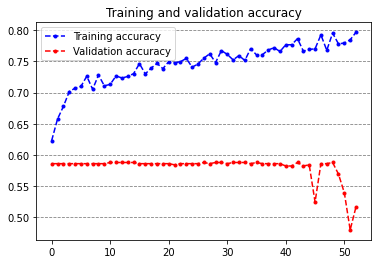

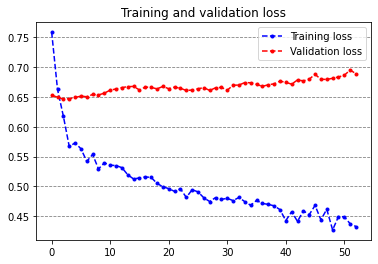

In [ ]:
# Save and load history
with open(HISTORY_PATH + '/ResNet50_FT_bm_history', 'wb') as file_pi:
        pickle.dump(ResNet50_FT_bm_history.history, file_pi)

ResNet50_FT_bm_history = pickle.load(open(HISTORY_PATH + '/ResNet50_FT_bm_history', "rb"))

visual.plot_history(ResNet50_FT_bm_history)

Load best weights and save:

In [ ]:
# If disconnection occur best weights so far are restored 

#best = tf.train.latest_checkpoint(CHECKPOINT_PATH + "/ResNet50_FT_bm/")
#ResNet50_FT_bm.load_weights(best)

In [ ]:
if not os.path.exists(MODELS_PATH):
  os.makedirs(MODELS_PATH)
ResNet50_FT_bm.save(os.path.join(MODELS_PATH,'ResNet50_FT_bm.h5'))

## Load Results

In [20]:
VGG16_TL_bm = keras.models.load_model(os.path.join(MODELS_PATH,'VGG16_TL_bm.h5'))

In [21]:
InceptionV3_TL_bm = keras.models.load_model(os.path.join(MODELS_PATH,'InceptionV3_TL_bm.h5'))

In [22]:
ResNet50_TL_bm = keras.models.load_model(os.path.join(MODELS_PATH,'ResNet50_TL_bm.h5'))

In [23]:
VGG16_FT_bm = keras.models.load_model(os.path.join(MODELS_PATH,'VGG16_FT_bm.h5'))

In [24]:
InceptionV3_FT_bm = keras.models.load_model(os.path.join(MODELS_PATH,'InceptionV3_FT_bm.h5'))

In [ ]:
ResNet50_FT_bm = keras.models.load_model(os.path.join(MODELS_PATH,'ResNet50_FT_bm.h5'))

## Support Vectors Machines 

Extract Features:

In [ ]:
FT_LAYER = -7 # FE starts from -7th layer

VGG16_TL_bm_fe = svm.create_feature_extractor(VGG16_TL_bm, FT_LAYER, layers.Flatten(name = "flatten"))
VGG16_TL_bm_fe.summary()

InceptionV3_TL_bm_fe = svm.create_feature_extractor(InceptionV3_TL_bm, FT_LAYER, layers.Flatten(name = "flatten"))
InceptionV3_TL_bm_fe.summary()

ResNet50_TL_bm_fe = svm.create_feature_extractor(ResNet50_TL_bm, FT_LAYER, layers.Flatten(name = "flatten"))
ResNet50_TL_bm_fe.summary()

VGG16_FT_bm_fe = svm.create_feature_extractor(VGG16_FT_bm, FT_LAYER, layers.Flatten(name = "flatten"))
VGG16_FT_bm_fe.summary()

InceptionV3_FT_bm_fe = svm.create_feature_extractor(InceptionV3_FT_bm, FT_LAYER, layers.Flatten(name = "flatten"))
InceptionV3_FT_bm_fe.summary()


Model: "VGG16_TL_mass_calcification_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________
Model: "InceptionV3_TL_mass_calcification_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
__

In [ ]:
m1_train_features, m1_val_features, m1_test_features = svm.extract_features(VGG16_TL_bm_fe, bm_train_images, bm_val_images, bm_test_images)
m2_train_features, m2_val_features, m2_test_features = svm.extract_features(InceptionV3_TL_bm_fe, bm_train_images, bm_val_images, bm_test_images)
m3_train_features, m3_val_features, m3_test_features = svm.extract_features(ResNet50_TL_bm_fe, bm_train_images, bm_val_images, bm_test_images)
m4_train_features, m4_val_features, m4_test_features = svm.extract_features(VGG16_FT_bm_fe, bm_train_images, bm_val_images, bm_test_images)
m5_train_features, m5_val_features, m5_test_features = svm.extract_features(InceptionV3_FT_bm_fe, bm_train_images, bm_val_images, bm_test_images)

Train SVM on extracted features:

In [ ]:
VGG16_TL_bm_SVM = svm.train_svm_classifier(m1_train_features, bm_train_labels, m1_val_features, bm_val_labels, ker = "linear", gam='scale', c = 8)

Accuracy on training set: 100.0%
Accuracy on validation set: 65.67%


In [ ]:
InceptionV3_TL_bm_SVM = svm.train_svm_classifier(m2_train_features, bm_train_labels, m2_val_features, bm_val_labels, ker = "rbf", gam='scale', c = 10)

In [ ]:
ResNet50_TL_bm_SVM = svm.train_svm_classifier(m3_train_features, bm_train_labels, m3_val_features, bm_val_labels, ker = "linear", gam='scale', c = 10)

In [ ]:
VGG16_FT_bm_SVM = svm.train_svm_classifier(m4_train_features, bm_train_labels, m4_val_features, bm_val_labels, ker = "linear", gam='scale', c = 8)

In [ ]:
InceptionV3_FT_bm_SVM = svm.train_svm_classifier(m5_train_features, bm_train_labels, m5_val_features, bm_val_labels, ker = "rbf", gam='scale', c = 100)

# Compare Results

##Scoring:

VGG16 -----------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


VGG16_TL
Accuracy on test set: 69.64% 
Loss on test set: 0.5891


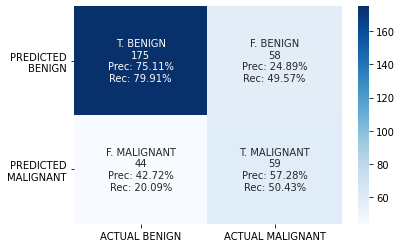

VGG16_FT
Accuracy on test set: 70.83% 
Loss on test set: 0.6135


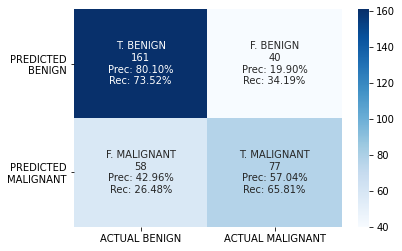

InceptionV3 -----------------------------------------------------------------
InceptionV3_TL
Accuracy on test set: 72.32% 
Loss on test set: 0.5921


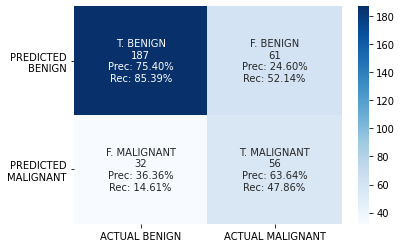

InceptionV3_FT
Accuracy on test set: 68.15% 
Loss on test set: 0.588


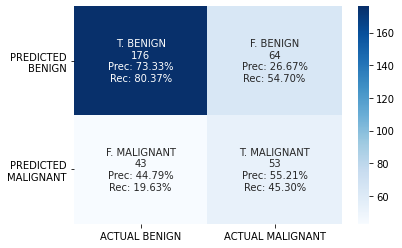

ResNet50 -----------------------------------------------------------------
ResNet50_TL
Accuracy on test set: 66.96% 
Loss on test set: 0.6168


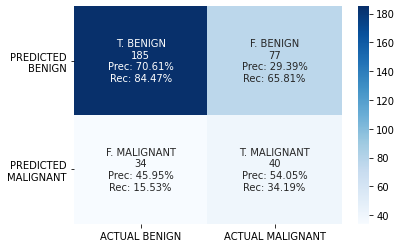

ResNet50_FT
Accuracy on test set: 65.18% 
Loss on test set: 0.6525


/content/drive/MyDrive/Petrocchi/util/visualization.ipynb:12: RuntimeWarning: invalid value encountered in long_scalars
/content/drive/MyDrive/Petrocchi/util/visualization.ipynb:13: RuntimeWarning: invalid value encountered in long_scalars


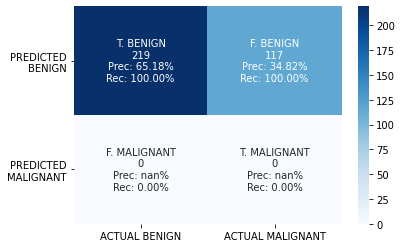

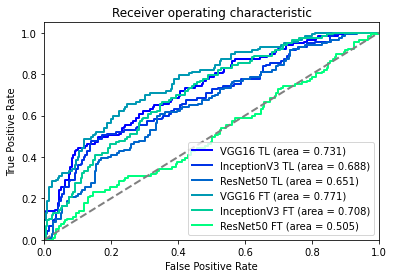

In [24]:
# VGG16 -----------------------------------------
print("VGG16 -----------------------------------------------------------------")

# Transfer Learning
test_loss, test_acc = VGG16_TL_bm.evaluate(bm_test_images, bm_test_labels)
print("VGG16_TL")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

VGG16_TL_bm_test_predictions = VGG16_TL_bm.predict(bm_test_images)
binary_VGG16_TL_bm_test_predictions = VGG16_TL_bm_test_predictions.round()
visual.plot_confusion_matrix(bm_test_labels, binary_VGG16_TL_bm_test_predictions, ["BENIGN", "MALIGNANT"])
'''
test_acc = VGG16_TL_bm_SVM.score(m1_test_features, bm_test_labels)
print("VGG16_TL_SVG")
print(f"Accuracy on test set: {round(test_acc*100, 2)}%")

VGG16_TL_bm_SVM_test_predictions = VGG16_TL_bm_SVM.predict_proba(m1_test_features)
binary_VGG16_TL_bm_SVM_test_predictions = VGG16_TL_bm_SVM_test_predictions[:,1].round()
visual.plot_confusion_matrix(bm_test_labels, binary_VGG16_TL_bm_SVM_test_predictions, ["BENIGN", "MALIGNANT"])
'''
# Fine Tuning
test_loss, test_acc = VGG16_FT_bm.evaluate(bm_test_images, bm_test_labels)
print("VGG16_FT")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

VGG16_FT_bm_test_predictions = VGG16_FT_bm.predict(bm_test_images)
binary_VGG16_FT_bm_test_predictions = VGG16_FT_bm_test_predictions.round()
visual.plot_confusion_matrix(bm_test_labels, binary_VGG16_FT_bm_test_predictions, ["BENIGN", "MALIGNANT"])

# InceptionV3 -----------------------------------------
print("InceptionV3 -----------------------------------------------------------------")

# Transfer Learning
test_loss, test_acc = InceptionV3_TL_bm.evaluate(bm_test_images, bm_test_labels)
print("InceptionV3_TL")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

InceptionV3_TL_bm_test_predictions = InceptionV3_TL_bm.predict(bm_test_images)
binary_InceptionV3_TL_bm_test_predictions = InceptionV3_TL_bm_test_predictions.round()
visual.plot_confusion_matrix(bm_test_labels, binary_InceptionV3_TL_bm_test_predictions, ["BENIGN", "MALIGNANT"])

# Fine Tuning
test_loss, test_acc = InceptionV3_FT_bm.evaluate(bm_test_images, bm_test_labels)
print("InceptionV3_FT")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

InceptionV3_FT_bm_test_predictions = InceptionV3_FT_bm.predict(bm_test_images)
binary_InceptionV3_FT_bm_test_predictions = InceptionV3_FT_bm_test_predictions.round()
visual.plot_confusion_matrix(bm_test_labels, binary_InceptionV3_FT_bm_test_predictions, ["BENIGN", "MALIGNANT"])

# ResNet50 -----------------------------------------
print("ResNet50 -----------------------------------------------------------------")

# Transfer Learning
test_loss, test_acc = ResNet50_TL_bm.evaluate(bm_test_images, bm_test_labels)
print("ResNet50_TL")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

ResNet50_TL_bm_test_predictions = ResNet50_TL_bm.predict(bm_test_images)
binary_ResNet50_TL_bm_test_predictions = ResNet50_TL_bm_test_predictions.round()
visual.plot_confusion_matrix(bm_test_labels, binary_ResNet50_TL_bm_test_predictions, ["BENIGN", "MALIGNANT"])

# Fine Tuning
test_loss, test_acc = ResNet50_FT_bm.evaluate(bm_test_images, bm_test_labels)
print("ResNet50_FT")
print(f"Accuracy on test set: {round(test_acc*100, 2)}% \nLoss on test set: {round(test_loss,4)}")

ResNet50_FT_bm_test_predictions = ResNet50_FT_bm.predict(bm_test_images)
binary_ResNet50_FT_bm_test_predictions = ResNet50_FT_bm_test_predictions.round()
visual.plot_confusion_matrix(bm_test_labels, binary_ResNet50_FT_bm_test_predictions, ["BENIGN", "MALIGNANT"])


# ROC -------------------------------------------------------------------------------------
models_predictions = [VGG16_TL_bm_test_predictions,
                      InceptionV3_TL_bm_test_predictions,
                      ResNet50_TL_bm_test_predictions,
                      VGG16_FT_bm_test_predictions,
                      InceptionV3_FT_bm_test_predictions,
                      ResNet50_FT_bm_test_predictions           
                     ]


visual.plot_roc_curve(bm_test_labels, models_predictions, ["VGG16 TL","InceptionV3 TL","ResNet50 TL", "VGG16 FT","InceptionV3 FT","ResNet50 FT"])


##Visual Results:

In [ ]:
# Filters patterns
visual.display_filters_patterns_RGB(top_k = len(VGG16_TL_base.layers), model = VGG16_TL_base, size = 150, images_per_row = 16, scale = 1, grad_steps = 40)

In [ ]:
#Example Image
img_index = 33
IMG = bm_test_images[img_index:img_index + 1] # visualized image

plt.imshow(preprocessing.deprocess_image(IMG[0,:,:,0]),cmap = 'gray')
if bm_test_labels[img_index] == 0:
  plt.title("BENIGN")
else:
  plt.title("MALIGNANT")
plt.show()

In [ ]:
# Feature Maps
visual.display_features_maps(bottom_layer = 1, top_k = len(VGG16_TL_base.layers) - 1, model = VGG16_TL_base, example_image = IMG, images_per_row = 16, scale = 1)

Author: **Stefano Petrocchi**
